<a href="https://colab.research.google.com/github/flying-bear/modeling_schizo/blob/master/Apply_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import seaborn as sns

from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm
from scipy import stats
from statsmodels.stats.multitest import multipletests

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tqdm.pandas()

In [0]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [0]:
def cos_sim(v1, v2):
    return np.inner(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

# Data

In [0]:
with open('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/applied.pickle', 'rb') as f:
  data = pickle.load(f)

In [0]:
tests = ['child', 'chair', 'gift', 'suit']

In [0]:
data.columns

Index(['child', 'gift', 'suit', 'chair', 'child_edus', 'child_utt_num',
       'child_edu_num', 'chair_edus', 'chair_utt_num', 'chair_edu_num',
       'gift_edus', 'gift_utt_num', 'gift_edu_num', 'suit_edus',
       'suit_utt_num', 'suit_edu_num', 'child_lemmas', 'chair_lemmas',
       'gift_lemmas', 'suit_lemmas', 'child_mean_edu_len', 'child_min_edu_len',
       'child_max_edu_len', 'child_word_count', 'chair_mean_edu_len',
       'chair_min_edu_len', 'chair_max_edu_len', 'chair_word_count',
       'gift_mean_edu_len', 'gift_min_edu_len', 'gift_max_edu_len',
       'gift_word_count', 'suit_mean_edu_len', 'suit_min_edu_len',
       'suit_max_edu_len', 'suit_word_count', 'child_lemmas_w2v',
       'chair_lemmas_w2v', 'gift_lemmas_w2v', 'suit_lemmas_w2v', 'child_sif',
       'chair_sif', 'gift_sif', 'child_elmo', 'chair_elmo', 'gift_elmo',
       'suit_elmo', 'child_bert', 'chair_bert', 'gift_bert', 'suit_bert',
       'suit_sif'],
      dtype='object')

In [0]:
data = data[['child_sif', 'chair_sif', 'gift_sif', 'suit_sif', 
             'child_elmo', 'chair_elmo', 'gift_elmo', 'suit_elmo', 
             'child_bert', 'chair_bert', 'gift_bert', 'suit_bert']]

In [84]:
data.tail(2)

,child,gift,suit,chair,child_edus,child_utt_num,child_edu_num,chair_edus,chair_utt_num,chair_edu_num,gift_edus,gift_utt_num,gift_edu_num,suit_edus,suit_utt_num,suit_edu_num,child_lemmas,chair_lemmas,gift_lemmas,suit_lemmas,child_mean_edu_len,child_min_edu_len,child_max_edu_len,child_word_count,chair_mean_edu_len,chair_min_edu_len,chair_max_edu_len,chair_word_count,gift_mean_edu_len,gift_min_edu_len,gift_max_edu_len,gift_word_count,suit_mean_edu_len,suit_min_edu_len,suit_max_edu_len,suit_word_count,child_lemmas_w2v,chair_lemmas_w2v,gift_lemmas_w2v,suit_lemmas_w2v,child_sif,chair_sif,gift_sif,child_elmo,chair_elmo,gift_elmo,suit_elmo,child_bert,chair_bert,gift_bert,suit_bert,suit_sif
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S20,//на этой на коляс= · о(0.3) · //на этой ...,//вот ну мне моя девушка испекла торт · (0.8...,//ну значит был человек · /который очень сте...,//вот ну в начале делаются ну по бокам ножки ...,"[[на, этой, на], [на, этой, странице, видно], ...",14,19,"[[вот, ну, в, начале, делаются, ну, по, бокам,...",11.0,13.0,"[[вот, ну, мне, моя, девушка, испекла, торт, о...",4.0,4.0,"[[ну, значит, был, человек], [который, очень, ...",8.0,14.0,"[[на, этот, на], [на, этот, страница, видно], ...","[[вот, ну, в, начало, делаться, ну, по, бок, н...","[[вот, ну, я, мой, девушка, испечь, торт, очен...","[[ну, значит, быть, человек], [который, очень,...",3.944444,2,8,71,5.25,1.0,9.0,63.0,6.666667,4.0,10.0,20.0,4.461538,2.0,8.0,58.0,"[[0.222128924013332, 1.2875648494137681, -0.11...","[[-0.6020894420902853, 0.02540478748258282, 0....","[[-0.5898330591742473, 0.5081242803436881, -0....","[[-0.17692534680612773, 0.8580223354100827, 0....","[[-0.1309083046597268, 1.5931118150382497, -0....","[[-1.353279945076223, 0.6755457928830055, -0.1...","[[-0.5361064549577625, 0.4616249325175217, -0....","[[-0.2780114, -0.57365817, 0.22401376, -2.2336...","[[-0.5764583, -0.21059678, 0.061395194, -0.256...","[[-0.06162157, -0.3700385, 0.7188135, 0.072670...","[[-0.6554408, -1.5173392, 0.5360127, -0.062073...","[[0.65086037, 0.30297586, 0.8016355, 0.4996233...","[[1.0759436, -0.049940437, 0.31772918, 0.30023...","[[1.1465244, -0.18004239, 0.045954917, 0.18331...","[[0.8262927, 0.40695453, 0.7690175, 0.12168455...","[[-0.2715050042549043, 0.9398792190364805, 0.5..."
S21,//ну началось с того · /что малыш с мамой с ...,NaN,//ну здесь встретились два мужчины · //один ...,NaN,"[[ну, началось, с, того], [что, малыш, с, мамо...",31,41,NaN,NaN,NaN,NaN,NaN,NaN,"[[ну, здесь, встретились, два, мужчины], [один...",16.0,20.0,"[[ну, начаться, с, тот], [что, малыш, с, мама,...",NaN,NaN,"[[ну, здесь, встретиться, два, мужчина], [один...",4.700000,1,12,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.894737,2.0,11.0,112.0,"[[-1.321632768280418, 2.433630768626983, -0.97...",NaN,NaN,"[[0.9249569663388714, 0.9475429219909582, -1.8...","[[-0.46076551556873424, 1.6885666351354667, -0...",NaN,NaN,"[[-0.7621543, -0.8216656, -0.3929461, -1.32644...",NaN,NaN,"[[-0.45703903, -0.48333216, 1.1214621, 0.24196...","[[0.6989477, 0.4510869, 0.757079, 0.75145894, ...",NaN,NaN,"[[0.38941172, 0.44076353, 0.22852577, 0.519196...","[[1.6140930878184254, 0.3511087962990732, -1.2..."


In [0]:
data['binary_diagnosis'] = [1 if 'H' in i else 0 for i in data.index]

## Plotting and averaging


In [0]:
def average_text_vector_dict(array_of_arrays):
    """
    gets minimum, median, and maximun for each list in input

    :param array_of_arrays: lsit of lists of int or float

    :return: dict of lists,
        keys: {'min','med','max'}
        values: float or int, min, median, maximum of each list in input
    """
    max_len = max([len(x) for x in array_of_arrays])
    result_dict = {'min':[],'med':[],'max':[]}
    for i in range(max_len):
        current = []
        for arr in array_of_arrays:
            try:
                current.append(arr[i])
            except IndexError:
                continue
        if current is not None:
            result_dict['min'].append(min(current))
            result_dict['max'].append(max(current))
            result_dict['med'].append(np.median(current))
        else:
            print(i, max_len)
    return result_dict

In [0]:
def plot_average(result_dict, labels={'med':'median', 'min':'minimum', 'max':'maximum'},
                 colors={'med':'r', 'min':'#fd5c74', 'max':'#fd5c74'}, title='averaged metric'):
  """
  plots average_dict result

  :param result_dict: dict of lists,
        keys: {'min','med','max'}
        values: float or int, min, median, maximum of each list in input
  :param labels: dict of lables
        keys: {'min','med','max'}
        values: str, full label
  :param colors: dict of colors
        keys: {'min','med','max'}
        values: str, colors
  """
  length = len(result_dict['med'])
  plt.plot(np.arange(length)+1, result_dict['med'], color=colors['med'], label=labels['med'], linestyle='-')
  plt.plot(np.arange(length)+1, result_dict['min'], color=colors['min'], label=labels['min'], linestyle=':')
  plt.plot(np.arange(length)+1, result_dict['max'], color=colors['max'], label=labels['max'], linestyle=':')
  plt.title(label=title)
  plt.legend()
  plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})

# Semi-local coherence
#### cumulative semi-local coherence
a plot: <br>
x axis: distance between the clauses (measured in clauses or words) <br>
y axis: cosine distance between an averaged vector of the first <i>n</i> clauses and the current clause

In [0]:
def get_cumulative_semi_loc_coh_array(clause_vectors):
  """
  calculates cummulative coherence
  :param clause_vectors: list of np.arrays (vectors) or a np.array of shape (sent_len, emb_size)

  :return: list of float of len sent_len, cummulative coherence of each clasue
  """
  cumulative_semi_loc_coh_array = []
  for i in range(len(clause_vectors)):
      if i:
          cumulative_semi_loc_coh_array.append(
              cos_sim(np.mean(clause_vectors[:i], axis=0), clause_vectors[i]))
  return cumulative_semi_loc_coh_array

In [0]:
get_cumulative_semi_loc_coh_array(data['child_elmo']['S01'])

[0.44718066,
 0.62662923,
 0.46851102,
 0.5704978,
 0.52095497,
 0.6464621,
 0.667204,
 0.6685148,
 0.73535234,
 0.502023,
 0.6746772]

In [0]:
for col in tests:
  data[f'{col}_cum_semi_loc_coh_sif'] = data[f'{col}_sif' ][~pd.isnull(data[f'{col}_sif' ])].apply(get_cumulative_semi_loc_coh_array)
  data[f'{col}_mean_semi_loc_coh_sif'] = data[f'{col}_cum_semi_loc_coh_sif'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_sif'])].apply(np.mean)
  data[f'{col}_max_semi_loc_coh_sif'] = data[f'{col}_cum_semi_loc_coh_sif'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_sif'])].apply(max)
  data[f'{col}_min_semi_loc_coh_sif'] = data[f'{col}_cum_semi_loc_coh_sif'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_sif'])].apply(min)

In [0]:
for col in tests:
  data[f'{col}_cum_semi_loc_coh_bert'] = data[f'{col}_bert' ][~pd.isnull(data[f'{col}_bert' ])].apply(get_cumulative_semi_loc_coh_array)
  data[f'{col}_mean_semi_loc_coh_bert'] = data[f'{col}_cum_semi_loc_coh_bert'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_bert'])].apply(np.mean)
  data[f'{col}_max_semi_loc_coh_bert'] = data[f'{col}_cum_semi_loc_coh_bert'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_bert'])].apply(max)
  data[f'{col}_min_semi_loc_coh_bert'] = data[f'{col}_cum_semi_loc_coh_bert'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_bert'])].apply(min)

In [0]:
for col in tests:
  data[f'{col}_cum_semi_loc_coh_elmo'] = data[f'{col}_elmo' ][~pd.isnull(data[f'{col}_elmo' ])].apply(get_cumulative_semi_loc_coh_array)
  data[f'{col}_mean_semi_loc_coh_elmo'] = data[f'{col}_cum_semi_loc_coh_elmo'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_elmo'])].apply(np.mean)
  data[f'{col}_max_semi_loc_coh_elmo'] = data[f'{col}_cum_semi_loc_coh_elmo'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_elmo'])].apply(max)
  data[f'{col}_min_semi_loc_coh_elmo'] = data[f'{col}_cum_semi_loc_coh_elmo'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_elmo'])].apply(min)

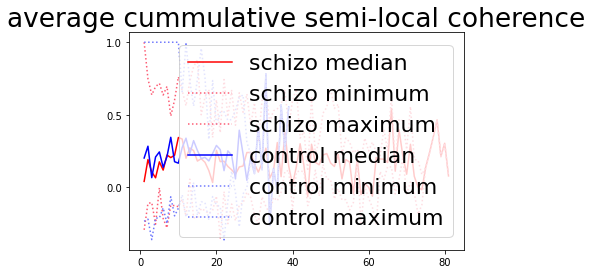

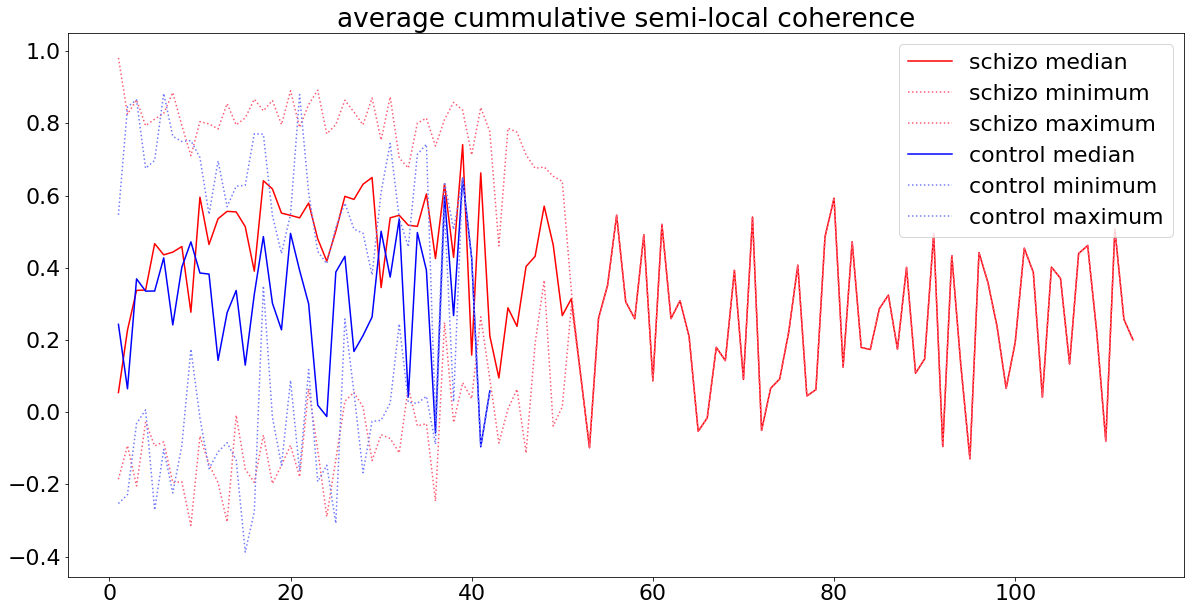

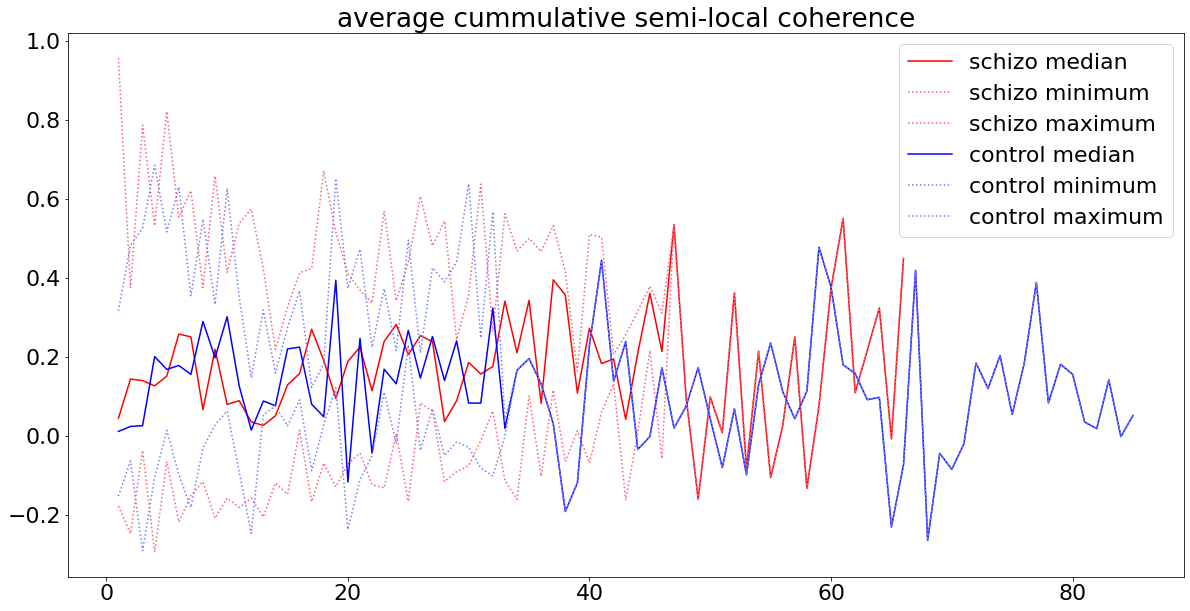

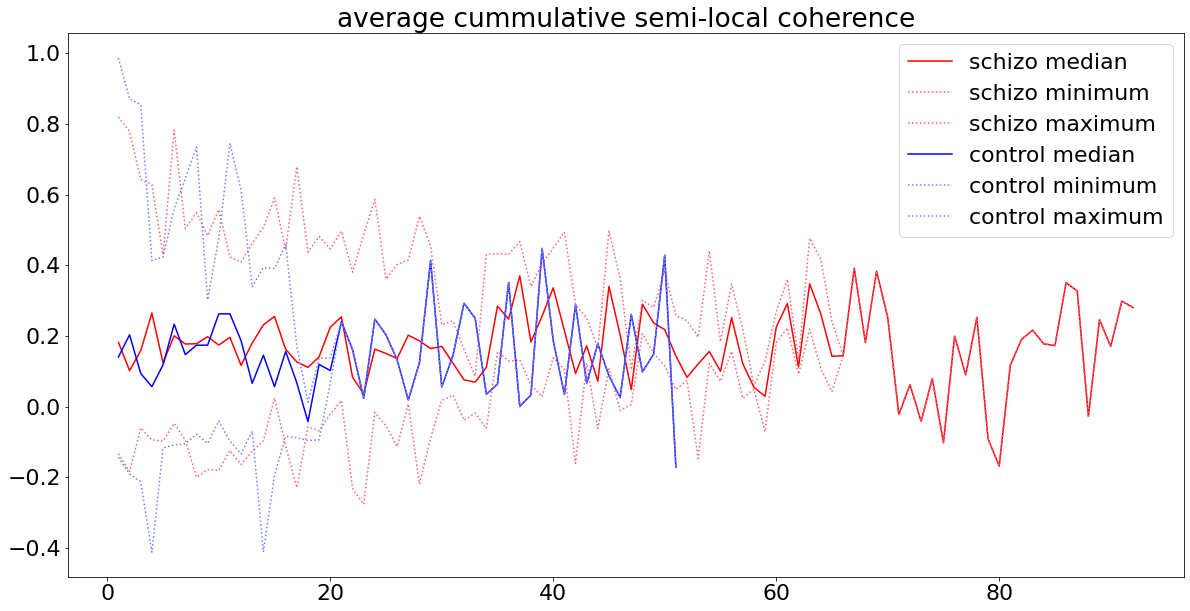

In [0]:
for col in tests:
  min_c, med_c, max_c, min_s, med_s, max_s = data[~pd.isnull(data[f'{col}_cum_semi_loc_coh_sif'])].groupby('binary_diagnosis')[f'{col}_cum_semi_loc_coh_sif' ].apply(average_text_vector_dict)
  dict_control =  {'min': min_c, 'max': max_c, 'med': med_c}
  dict_schizo = {'min': min_s, 'max': max_s, 'med':med_s}
  plot_average(dict_schizo, labels={'med':'schizo median', 'min':'schizo minimum', 'max':'schizo maximum'})
  plot_average(dict_control, labels={'med':'control median', 'min':'control minimum', 'max':'control maximum'}, 
             colors={'med':'b', 'min':'#717afd', 'max':'#717afd'}, title='average cummulative semi-local coherence')
  plt.show()

# Local coherence
(let i = cosine distance between an averaged vector of the neighbouring clauses)  <br>
a plot:  <br>
 x axis: number of the current clause <br>
 y axis: i
- the differences between the averages for the groups
- the differences between the averages for the averages of the groups

In [0]:
def get_local_coherence_array(clause_vectors):
    """
    calculates local coherence
    
    :param clause_vectors: list of np.arrays (vectors) or a np.array of shape (sent_len, emb_size)
    :return: list of float of len sent_len, local coherence of each clasue
    """
    local_coherence_array = []
    length = len(clause_vectors)
    for i in range(length-1):
        local_coherence_array.append(cos_sim(clause_vectors[i], clause_vectors[i+1]))
    return local_coherence_array

In [0]:
methods = ['sif', 'bert', 'elmo']

In [0]:
for col in tests:
  for method in methods:
    data[f'{col}_loc_coh_{method}'] = data[f'{col}_{method}' ][~pd.isnull(data[f'{col}_{method}' ])].apply(get_cumulative_semi_loc_coh_array)
    data[f'{col}_mean_loc_coh_{method}'] = data[f'{col}_loc_coh_{method}'][~pd.isnull(data[f'{col}_loc_coh_{method}'])].apply(np.mean)
    data[f'{col}_max_loc_coh_{method}'] = data[f'{col}_loc_coh_{method}'][~pd.isnull(data[f'{col}_loc_coh_{method}'])].apply(max)
    data[f'{col}_min_loc_coh_{method}'] = data[f'{col}_loc_coh_{method}'][~pd.isnull(data[f'{col}_loc_coh_{method}'])].apply(min)

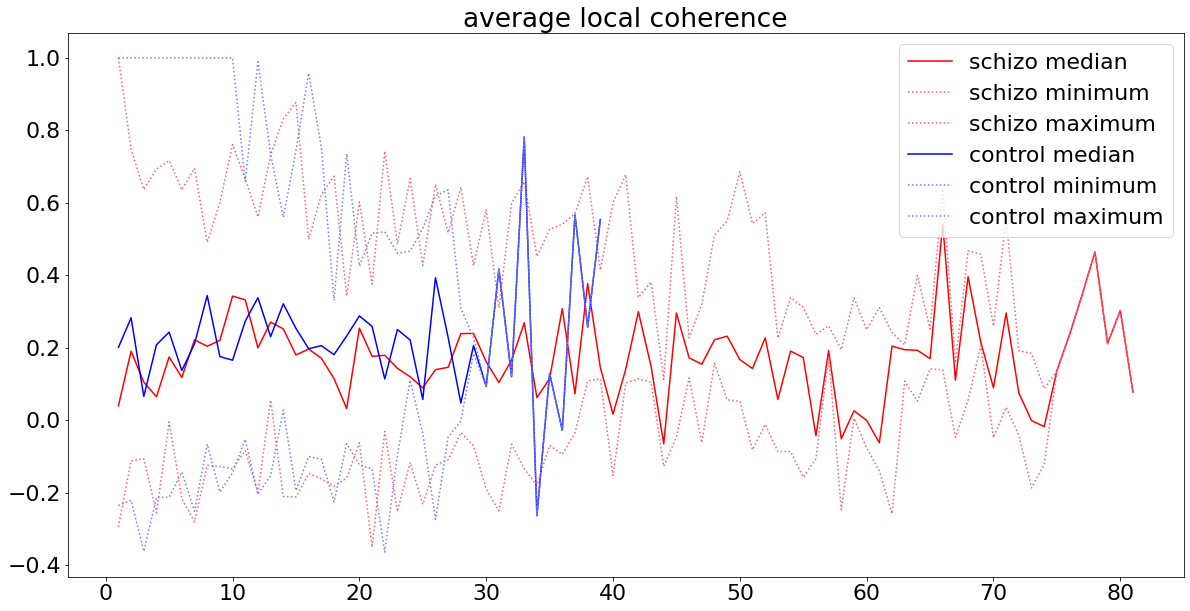

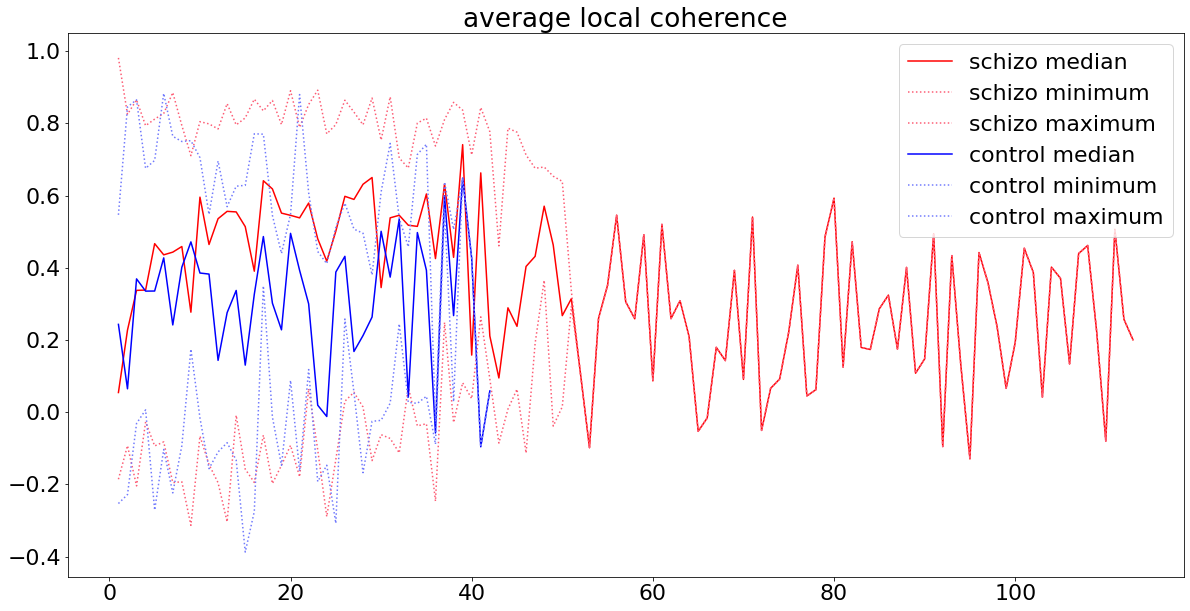

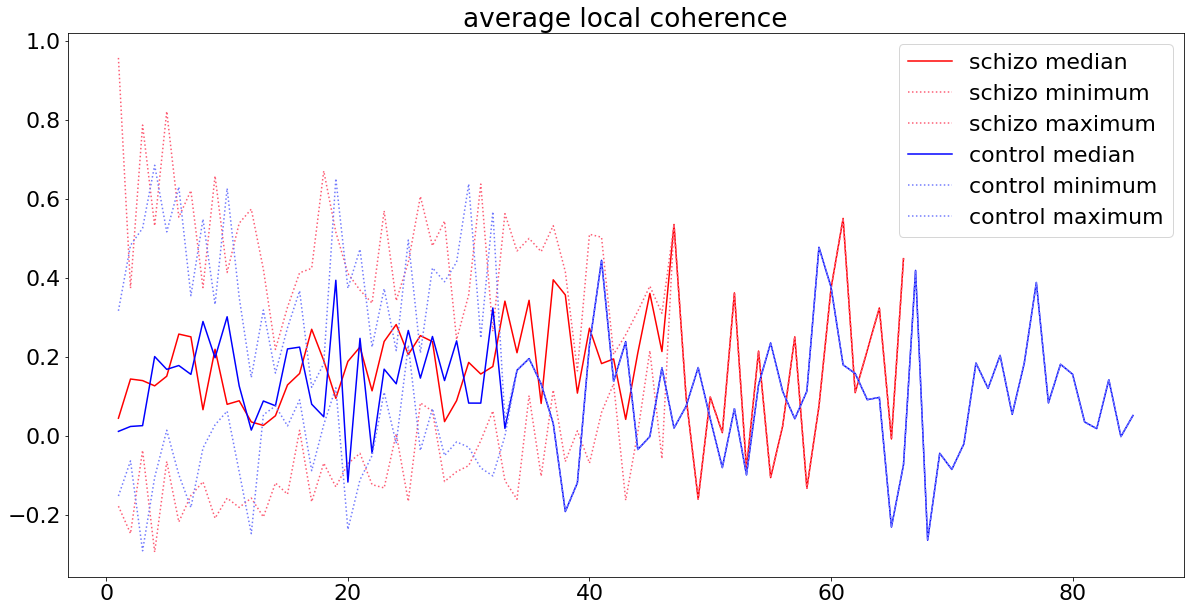

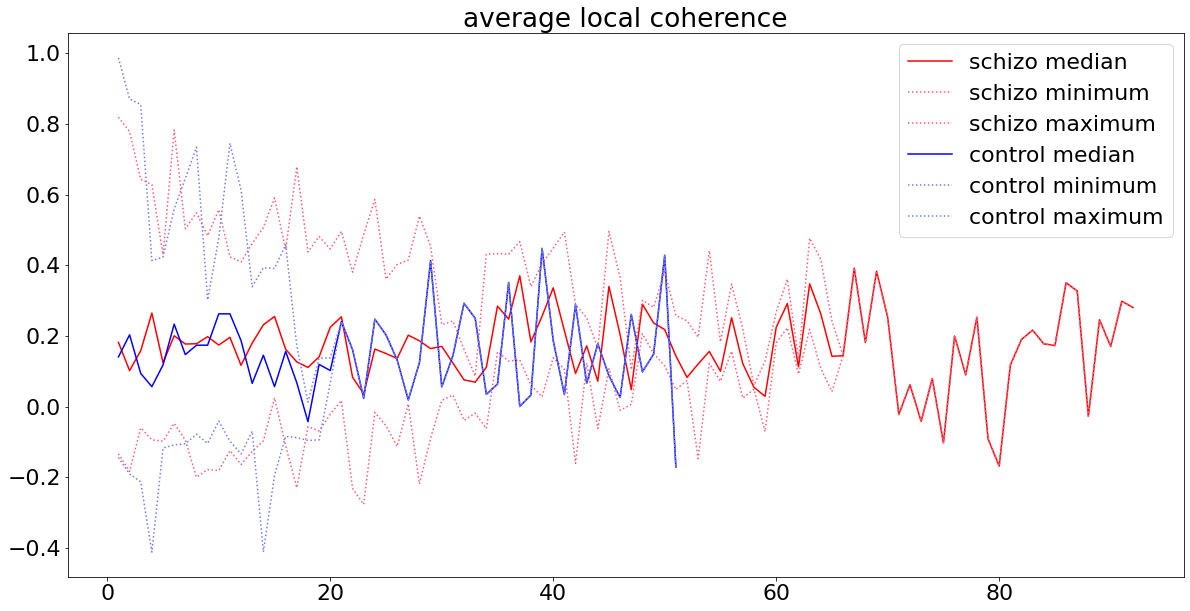

In [0]:
for col in tests:
  min_c, med_c, max_c, min_s, med_s, max_s = data[~pd.isnull(data[f'{col}_loc_coh_sif'])].groupby('binary_diagnosis')[f'{col}_loc_coh_sif' ].apply(average_text_vector_dict)
  dict_control =  {'min': min_c, 'max': max_c, 'med': med_c}
  dict_schizo = {'min': min_s, 'max': max_s, 'med':med_s}
  plot_average(dict_schizo, labels={'med':'schizo median', 'min':'schizo minimum', 'max':'schizo maximum'})
  plot_average(dict_control, labels={'med':'control median', 'min':'control minimum', 'max':'control maximum'}, 
             colors={'med':'b', 'min':'#717afd', 'max':'#717afd'}, title='average local coherence')
  plt.show()

## Global coherence
(let us take a weighted average of each clause, then an average of these centroids in one text, then a average of the averages of all the texts at hand)
- cosine distance between the average of all the texts and the average of the current text for each participant
- cosine distance between the average of all the <i>control</i> texts and the average of the current text for each participant

In [0]:
def compare_text_to_a_standard_vector(clause_vectors, standard_vector):
    """
    cosine similarity of a given vector and a list of vectors

    :param clause_vectors: list of np.arrays (vectors) or a np.array of shape (sent_len, emb_size)
    :param standard_vector: np.array of int or float of shape (emb_size)
    """
    average_file_vector = np.average(clause_vectors, axis=0)
    return cos_sim(average_file_vector, standard_vector)

In [0]:
def get_standard_vectors(data, column_name):
  """
  gets average vector across all vectors in a givem column, unlisting them

  :param data: pd.Dataframe
  :column_name: str, column with list of lists or np.arrays of int ot float of shape (sent_len, emb_size)
  :return: np.array of int or float of shape (emb_size)
  """
  column = data[column_name][~pd.isnull(data[column_name])]
  return np.mean(flatten(column.values), axis=0)

In [0]:
def get_global_coherence(clause_vectors, standard_vector):
    """
    calculates global coherence

    :param clause_vectors: list of np.arrays (vectors) or a np.array of shape (sent_len, emb_size)
    :param standard_vector:  np.array of int or float of shape (emb_size)
    :return: list of float of len sent_len, global coherence of each clasue
    """
    return [cos_sim(vec, standard) for vec in clause_vectors]

### All

In [0]:
for col in tests:
  for method in methods:
    standard  = get_standard_vectors(data, f'{col}_{method}')
    data[f'{col}_glob_coh_{method}'] = data[f'{col}_{method}'][~pd.isnull(data[f'{col}_{method}'])].apply(lambda vecs: get_global_coherence(vecs, standard))
    data[f'{col}_mean_glob_coh_{method}'] = data[f'{col}_glob_coh_{method}'][~pd.isnull(data[f'{col}_glob_coh_{method}'])].apply(np.mean)
    data[f'{col}_max_glob_coh_{method}'] = data[f'{col}_glob_coh_{method}'][~pd.isnull(data[f'{col}_glob_coh_{method}'])].apply(max)
    data[f'{col}_min_glob_coh_{method}'] = data[f'{col}_glob_coh_{method}'][~pd.isnull(data[f'{col}_glob_coh_{method}'])].apply(min)

### Control

In [0]:
for col in tests:
  for method in methods:
    standard  = get_standard_vectors(data[data['binary_diagnosis'] == 0], f'{col}_{method}')
    data[f'{col}_control_glob_coh_{method}'] = data[f'{col}_{method}'][~pd.isnull(data[f'{col}_{method}'])].apply(lambda vecs: get_global_coherence(vecs, standard))
    data[f'{col}_mean_control_glob_coh_{method}'] = data[f'{col}_control_glob_coh_{method}'][~pd.isnull(data[f'{col}_control_glob_coh_{method}'])].apply(np.mean)
    data[f'{col}_max_control_glob_coh_{method}'] = data[f'{col}_control_glob_coh_{method}'][~pd.isnull(data[f'{col}_control_glob_coh_{method}'])].apply(max)
    data[f'{col}_min_control_glob_coh_{method}'] = data[f'{col}_control_glob_coh_{method}'][~pd.isnull(data[f'{col}_control_glob_coh_{method}'])].apply(min)

# Maximal distance coherence

In [0]:
data.tail(2)

,child_sif,chair_sif,gift_sif,suit_sif,child_elmo,chair_elmo,gift_elmo,suit_elmo,child_bert,chair_bert,gift_bert,suit_bert,binary_diagnosis,child_cum_semi_loc_coh_sif,child_mean_semi_loc_coh_sif,child_max_semi_loc_coh_sif,child_min_semi_loc_coh_sif,chair_cum_semi_loc_coh_sif,chair_mean_semi_loc_coh_sif,chair_max_semi_loc_coh_sif,chair_min_semi_loc_coh_sif,gift_cum_semi_loc_coh_sif,gift_mean_semi_loc_coh_sif,gift_max_semi_loc_coh_sif,gift_min_semi_loc_coh_sif,suit_cum_semi_loc_coh_sif,suit_mean_semi_loc_coh_sif,suit_max_semi_loc_coh_sif,suit_min_semi_loc_coh_sif,child_cum_semi_loc_coh_bert,child_mean_semi_loc_coh_bert,child_max_semi_loc_coh_bert,child_min_semi_loc_coh_bert,chair_cum_semi_loc_coh_bert,chair_mean_semi_loc_coh_bert,chair_max_semi_loc_coh_bert,chair_min_semi_loc_coh_bert,gift_cum_semi_loc_coh_bert,gift_mean_semi_loc_coh_bert,gift_max_semi_loc_coh_bert,...,child_control_glob_coh_elmo,child_mean_control_glob_coh_elmo,child_max_control_glob_coh_elmo,child_min_control_glob_coh_elmo,chair_control_glob_coh_sif,chair_mean_control_glob_coh_sif,chair_max_control_glob_coh_sif,chair_min_control_glob_coh_sif,chair_control_glob_coh_bert,chair_mean_control_glob_coh_bert,chair_max_control_glob_coh_bert,chair_min_control_glob_coh_bert,chair_control_glob_coh_elmo,chair_mean_control_glob_coh_elmo,chair_max_control_glob_coh_elmo,chair_min_control_glob_coh_elmo,gift_control_glob_coh_sif,gift_mean_control_glob_coh_sif,gift_max_control_glob_coh_sif,gift_min_control_glob_coh_sif,gift_control_glob_coh_bert,gift_mean_control_glob_coh_bert,gift_max_control_glob_coh_bert,gift_min_control_glob_coh_bert,gift_control_glob_coh_elmo,gift_mean_control_glob_coh_elmo,gift_max_control_glob_coh_elmo,gift_min_control_glob_coh_elmo,suit_control_glob_coh_sif,suit_mean_control_glob_coh_sif,suit_max_control_glob_coh_sif,suit_min_control_glob_coh_sif,suit_control_glob_coh_bert,suit_mean_control_glob_coh_bert,suit_max_control_glob_coh_bert,suit_min_control_glob_coh_bert,suit_control_glob_coh_elmo,suit_mean_control_glob_coh_elmo,suit_max_control_glob_coh_elmo,suit_min_control_glob_coh_elmo
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S20,"[[-0.1309083046597268, 1.5931118150382497, -0....","[[-1.353279945076223, 0.6755457928830055, -0.1...","[[-0.5361064549577625, 0.4616249325175217, -0....","[[-0.2715050042549043, 0.9398792190364805, 0.5...","[[-0.2780114, -0.57365817, 0.22401376, -2.2336...","[[-0.5764583, -0.21059678, 0.061395194, -0.256...","[[-0.06162157, -0.3700385, 0.7188135, 0.072670...","[[-0.6554408, -1.5173392, 0.5360127, -0.062073...","[[0.65086037, 0.30297586, 0.8016355, 0.4996233...","[[1.0759436, -0.049940437, 0.31772918, 0.30023...","[[1.1465244, -0.18004239, 0.045954917, 0.18331...","[[0.8262927, 0.40695453, 0.7690175, 0.12168455...",0,"[-0.07512423009877942, 0.07626164661649965, -0...",0.121953,0.378947,-0.113542,"[-0.03407262839323228, 0.44028526343549806, 0....",0.379141,0.605292,-0.034073,"[-0.13663397121532833, -0.03248994340132471]",-0.084562,-0.03249,-0.136634,"[-0.08707529422116413, -0.034208482180131915, ...",0.081589,0.231180,-0.093860,"[0.9127051, 0.8269497, 0.88340044, 0.86156356,...",0.894565,0.927211,0.82695,"[0.6573938, 0.8492549, 0.82924986, 0.8463569, ...",0.836487,0.902575,0.657394,"[0.7085042, 0.8725248]",0.790514,0.872525,...,"[0.39266503, 0.55081534, 0.70833987, 0.6677822...",0.640261,0.755344,0.392665,"[0.6873533130854005, 0.2620530588988563, 0.327...",0.499665,0.748805,0.241219,"[0.8193807, 0.87274677, 0.89726585, 0.8537289,...",0.872227,0.929228,0.819381,"[0.76131475, 0.3901128, 0.52075684, 0.68798417...",0.609484,0.761315,0.370966,"[0.3327048768257128, 0.1108577381862454, 0.278...",0.240588,0.332705,0.110858,"[0.8363912, 0.9043523, 0.9262464]",0.888997,0.926246,0.836391,"[0.81410784, 0.66060543, 0.74930644]",0.74134,0.814108,0.660605,"[-0.19300582047522244, 0.2538660579261322, 0.4...",0.239103,0.511934,-0.193006,"[0.90658724, 0.9142452, 0.91143394, 0.92169285...",0.906180,0.930642

In [0]:
ex = data['child_sif']['H01']
for i, el in enumerate(ex):
  if i > 0:
    sims = np.array([cos_sim(ex[i], v) for v in ex[:i]])
    print(np.min(sims))

0.039837555430350294
-0.0192721069913896
0.0679299687569165
-0.02326760836766515
4.128154251941355e-05
-0.16098506876499927
-0.1584600056149034
-0.09627088488082142
-0.12427684304957912
-0.12427684304957912
-0.057270161273262565
-0.10381597889466133
-0.17422230198724414
-0.12427684304957912
-0.12427684304957912
-0.1417810124605084
-0.18733452067136655
-0.06895899705373593
-0.1612713158741436
-0.16057961401788312
-0.17359107060151774
-0.15531128028227253
-0.13145214299323313
-0.2715266472759702
-0.13145214299323313
-0.13145214299323313
-0.1324334253357849
-0.0920351547825659
-0.13954866262484045
-0.1299271885299066
-0.14899193944319444
-0.19459485886393127


In [0]:
def get_minimal_coherence(clause_vectors):
    """
    calculates maximal cosine distance coherence

    :param clause_vectors: list of np.arrays (vectors) or a np.array of shape (sent_len, emb_size)
    :return: list of float of len sent_len - 1, maximal cosine distance coherence of each clasue
    """
    maximal_distance_sims = []
    for i, el in enumerate(clause_vectors):
      if i > 0:
        sims = np.array([cos_sim(clause_vectors[i], v) for v in clause_vectors[:i]])
        maximal_distance_sims.append(np.min(sims))
    return maximal_distance_sims

In [0]:
for col in tests:
  for method in methods:
    data[f'{col}_cum_coh_{method}'] = data[f'{col}_{method}'][~pd.isnull(data[f'{col}_{method}'])].apply(get_minimal_coherence)
    data[f'{col}_mean_cum_coh_{method}'] = data[f'{col}_cum_coh_{method}'][~pd.isnull(data[f'{col}_cum_coh_{method}'])].apply(np.mean)
    data[f'{col}_max_cum_coh_{method}'] = data[f'{col}_cum_coh_{method}'][~pd.isnull(data[f'{col}_cum_coh_{method}'])].apply(max)
    data[f'{col}_min_cum_coh_{method}'] = data[f'{col}_cum_coh_{method}'][~pd.isnull(data[f'{col}_cum_coh_{method}'])].apply(min)

In [0]:
to_csv = []
for col in tests:
  for method in methods:
    to_csv += [f'{col}_mean_cum_coh_{method}', f'{col}_max_cum_coh_{method}', f'{col}_min_cum_coh_{method}']

In [0]:
data[to_csv].to_csv('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/min_cum_coh.csv')

In [0]:
dtypes = pd.DataFrame(data.dtypes, columns = ['type'])
number_columns = dtypes[dtypes['type'] == np.float64].index

In [0]:
metric_names = {}
for column in number_columns:
  test = column.split('_')[0]
  average = column.split('_')[1]
  method = column.split('_')[-1]
  coh = '_'.join(column.split('_')[2:-1])
  if test not in metric_names:
    metric_names[test] = {coh: {average: {method: column}}}
  else:
    if coh not in metric_names[test]: 
      metric_names[test][coh] = {average: {method:column}}
    else:
      if average not in metric_names[test][coh]:
         metric_names[test][coh][average] = {method:column}
      else:
        metric_names[test][coh][average][method] = column

In [0]:
order = []
for test in metric_names:
  for coh in metric_names[test]:
    for average in metric_names[test][coh]:
      for method in metric_names[test][coh][average]:
        order.append(metric_names[test][coh][average][method])

In [0]:
data[order].to_csv('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/metrics.csv')

In [0]:
with open('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/metrics.pickle', 'wb') as f:
  pickle.dump(data, f)

# Try analyzing relevant pieces

In [0]:
with open('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/metrics.pickle', 'rb') as f:
  data = pickle.load(f)

In [0]:
def display_test(df, columns_to_test, target_column, test, nan_policy='omit', stat_name='x'):
    """
    shows a stats test result for a given list of columns with a key column
    
    :param df: pd.DataFrame
    :param columns_to_test: list of str, column names
    :param target_column: str, column name to test all others against
    :param test: func, stats test taking lists as inputs and returning a tuple of float, power and significance
    :param nan_policy: str, argument for the test, optional, default 'omit'
    :patam stat_name: str, the name of the test variable, optional, default 'x'
    
    :return: styled pd.DataFrame with test results
    """
    res = pd.DataFrame(columns=[stat_name, 'p', 'sig'], index=columns_to_test)

    for column in columns_to_test:
        r, p = list(test(df[target_column], df[column], nan_policy=nan_policy))
        res.loc[column] = [r, p, p<0.05]
    reject, pvalscorr = multipletests(res['p'], alpha= 0.05, method='b')[:2]
    res['bonf'], res['bonf_sig'] = pvalscorr, reject
    res = pd.DataFrame([list(res.loc[column]) for column in columns_to_test], columns=[stat_name, 'p', 'sig', 'bonf', 'bonf_sig'], index=columns_to_test)
    return res.sort_values(['p']).style.background_gradient(axis=0, cmap='Reds'), res

In [8]:
meta = pd.read_csv('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/All_psych.csv', index_col=0).apply(lambda s: s.apply(lambda x: int(x.split(',')[0])))
meta.head(2)

,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N
ID,,,,,,,,,
H01,2,0,27,22,4,30,16,7,7
H02,1,0,36,17,7,35,18,8,9


In [0]:
meta['binary_diagnosis'] = meta['diagnosis'].apply(lambda x: 1 if x == 1 or x == 2 else 0)

In [0]:
with_meta = pd.concat([meta, data[number_columns]], axis=1)

## chair

In [0]:
elmo_chair = []
sif_chair = []
for metric in metric_names['chair']:
  for average in metric_names['chair'][metric]:
    elmo_chair.append(metric_names['chair'][metric][average]['elmo'])
    sif_chair.append(metric_names['chair'][metric][average]['sif'])

In [0]:
sif_order = """chair_min_loc_coh_sif
chair_min_semi_loc_coh_sif
chair_min_cum_coh_sif
chair_min_control_glob_coh_sif
chair_min_glob_coh_sif
chair_mean_loc_coh_sif
chair_mean_semi_loc_coh_sif
chair_mean_cum_coh_sif
chair_mean_control_glob_coh_sif
chair_mean_glob_coh_sif
chair_max_loc_coh_sif
chair_max_semi_loc_coh_sif
chair_max_cum_coh_sif
chair_max_control_glob_coh_sif
chair_max_glob_coh_sif""".split()

In [0]:
elmo_order = [x.replace('sif', 'elmo') for x in sif_order]

In [46]:
styler, test = display_test(with_meta, elmo_chair+sif_chair, 'binary_diagnosis', lambda x, y, nan_policy: stats.ttest_ind(x, y, nan_policy=nan_policy, equal_var=False), stat_name='t')
test.loc[sif_order].sort_values(['p']).style.background_gradient(axis=0, cmap='Reds')

,t,p,sig,bonf,bonf_sig
chair_min_cum_coh_sif,9.951876,0.000000,True,0.000000,True
chair_min_loc_coh_sif,8.244050,0.000000,True,0.000000,True
chair_min_semi_loc_coh_sif,8.244050,0.000000,True,0.000000,True
chair_min_glob_coh_sif,7.854958,0.000000,True,0.000000,True
chair_mean_cum_coh_sif,7.329559,0.000000,True,0.000000,True
chair_min_control_glob_coh_sif,7.018500,0.000000,True,0.000000,True
chair_max_glob_coh_sif,-4.134363,0.000169,True,0.005064,True
chair_max_loc_coh_sif,-3.440847,0.001249,True,0.037468,True
chair_max_semi_loc_coh_sif,-3.440847,0.001249,True,0.037468,True
chair_max_control_glob_coh_sif,-3.446884,0.001319,True,0.039557,True


In [47]:
good_chair = list(test.loc[sif_chair][test['bonf_sig'] == True].index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [48]:
test.loc[elmo_order].style.background_gradient(axis=0, cmap='Reds')

,t,p,sig,bonf,bonf_sig
chair_min_loc_coh_elmo,1.751282,0.087135,False,1.000000,False
chair_min_semi_loc_coh_elmo,1.751282,0.087135,False,1.000000,False
chair_min_cum_coh_elmo,3.973387,0.000272,True,0.008165,True
chair_min_control_glob_coh_elmo,0.631652,0.530979,False,1.000000,False
chair_min_glob_coh_elmo,0.651177,0.518395,False,1.000000,False
chair_mean_loc_coh_elmo,-1.624461,0.111957,False,1.000000,False
chair_mean_semi_loc_coh_elmo,-1.624461,0.111957,False,1.000000,False
chair_mean_cum_coh_elmo,2.379294,0.022016,True,0.660477,False
chair_mean_control_glob_coh_elmo,-1.950691,0.058061,False,1.000000,False
chair_mean_glob_coh_elmo,-2.026568,0.049312,True,1.000000,False


In [50]:
good_chair += list(test.loc[elmo_chair][test['bonf_sig'] == True].index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [0]:
corr_test = ['PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 'TD']

In [82]:
for psych in corr_test:
  print(psych)
  styler, test = display_test(with_meta, elmo_chair+sif_chair, psych, stats.spearmanr, stat_name='r')
  display(test.loc[sif_order].style.background_gradient(axis=0, cmap='Reds'))

PANSS_Total


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_sif,0.077271,0.659069,False,1.000000,False
chair_min_semi_loc_coh_sif,0.077271,0.659069,False,1.000000,False
chair_min_cum_coh_sif,0.101024,0.563640,False,1.000000,False
chair_min_control_glob_coh_sif,0.014742,0.933016,False,1.000000,False
chair_min_glob_coh_sif,-0.135939,0.436189,False,1.000000,False
chair_mean_loc_coh_sif,-0.445881,0.007263,True,0.217890,False
chair_mean_semi_loc_coh_sif,-0.445881,0.007263,True,0.217890,False
chair_mean_cum_coh_sif,0.170997,0.326025,False,1.000000,False
chair_mean_control_glob_coh_sif,-0.300641,0.079281,False,1.000000,False
chair_mean_glob_coh_sif,-0.361456,0.032887,True,0.986602,False


PANSS_O


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_sif,0.017016,0.922713,False,1.000000,False
chair_min_semi_loc_coh_sif,0.017016,0.922713,False,1.000000,False
chair_min_cum_coh_sif,-0.008029,0.963489,False,1.000000,False
chair_min_control_glob_coh_sif,-0.010462,0.952436,False,1.000000,False
chair_min_glob_coh_sif,-0.172293,0.322318,False,1.000000,False
chair_mean_loc_coh_sif,-0.490360,0.002786,True,0.083570,False
chair_mean_semi_loc_coh_sif,-0.490360,0.002786,True,0.083570,False
chair_mean_cum_coh_sif,0.101578,0.561493,False,1.000000,False
chair_mean_control_glob_coh_sif,-0.384878,0.022429,True,0.672879,False
chair_mean_glob_coh_sif,-0.438650,0.008391,True,0.251715,False


PANSS_P


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_sif,0.099605,0.569161,False,1.000000,False
chair_min_semi_loc_coh_sif,0.099605,0.569161,False,1.000000,False
chair_min_cum_coh_sif,0.138615,0.427126,False,1.000000,False
chair_min_control_glob_coh_sif,0.000287,0.998695,False,1.000000,False
chair_min_glob_coh_sif,-0.127285,0.466216,False,1.000000,False
chair_mean_loc_coh_sif,-0.452273,0.006377,True,0.191303,False
chair_mean_semi_loc_coh_sif,-0.452273,0.006377,True,0.191303,False
chair_mean_cum_coh_sif,0.219503,0.205171,False,1.000000,False
chair_mean_control_glob_coh_sif,-0.275007,0.109848,False,1.000000,False
chair_mean_glob_coh_sif,-0.332661,0.050868,False,1.000000,False


PANSS_N


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_sif,0.007032,0.968020,False,1.000000,False
chair_min_semi_loc_coh_sif,0.007032,0.968020,False,1.000000,False
chair_min_cum_coh_sif,0.041830,0.811424,False,1.000000,False
chair_min_control_glob_coh_sif,-0.056124,0.748795,False,1.000000,False
chair_min_glob_coh_sif,-0.162899,0.349792,False,1.000000,False
chair_mean_loc_coh_sif,-0.439546,0.008243,True,0.247299,False
chair_mean_semi_loc_coh_sif,-0.439546,0.008243,True,0.247299,False
chair_mean_cum_coh_sif,0.118532,0.497663,False,1.000000,False
chair_mean_control_glob_coh_sif,-0.303252,0.076581,False,1.000000,False
chair_mean_glob_coh_sif,-0.364729,0.031222,True,0.936664,False


TD


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_sif,0.069416,0.691934,False,1.000000,False
chair_min_semi_loc_coh_sif,0.069416,0.691934,False,1.000000,False
chair_min_cum_coh_sif,0.156022,0.370780,False,1.000000,False
chair_min_control_glob_coh_sif,-0.000871,0.996040,False,1.000000,False
chair_min_glob_coh_sif,-0.119464,0.494261,False,1.000000,False
chair_mean_loc_coh_sif,-0.374931,0.026472,True,0.794148,False
chair_mean_semi_loc_coh_sif,-0.374931,0.026472,True,0.794148,False
chair_mean_cum_coh_sif,0.247415,0.151870,False,1.000000,False
chair_mean_control_glob_coh_sif,-0.228846,0.186058,False,1.000000,False
chair_mean_glob_coh_sif,-0.301671,0.078207,False,1.000000,False


In [93]:
good_chair = []
for psych in corr_test:
  print(psych)
  styler, test = display_test(with_meta, elmo_chair+sif_chair, psych, stats.spearmanr, stat_name='r')
  display(test.loc[elmo_order].style.background_gradient(axis=0, cmap='Reds'))
  good_chair += list(test[test['bonf_sig'] == True].index)

print(Counter(good_chair))

PANSS_Total


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_elmo,-0.091431,0.601418,False,1.000000,False
chair_min_semi_loc_coh_elmo,-0.091431,0.601418,False,1.000000,False
chair_min_cum_coh_elmo,-0.017028,0.922656,False,1.000000,False
chair_min_control_glob_coh_elmo,0.053374,0.760736,False,1.000000,False
chair_min_glob_coh_elmo,0.034197,0.845376,False,1.000000,False
chair_mean_loc_coh_elmo,-0.631287,0.000048,True,0.001433,True
chair_mean_semi_loc_coh_elmo,-0.631287,0.000048,True,0.001433,True
chair_mean_cum_coh_elmo,-0.180000,0.300809,False,1.000000,False
chair_mean_control_glob_coh_elmo,-0.445421,0.007331,True,0.219922,False
chair_mean_glob_coh_elmo,-0.507090,0.001878,True,0.056332,False


PANSS_O


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_elmo,-0.191505,0.270440,False,1.000000,False
chair_min_semi_loc_coh_elmo,-0.191505,0.270440,False,1.000000,False
chair_min_cum_coh_elmo,-0.172735,0.321059,False,1.000000,False
chair_min_control_glob_coh_elmo,-0.050016,0.775392,False,1.000000,False
chair_min_glob_coh_elmo,-0.073508,0.674736,False,1.000000,False
chair_mean_loc_coh_elmo,-0.707537,0.000002,True,0.000060,True
chair_mean_semi_loc_coh_elmo,-0.707537,0.000002,True,0.000060,True
chair_mean_cum_coh_elmo,-0.330714,0.052323,False,1.000000,False
chair_mean_control_glob_coh_elmo,-0.532678,0.000987,True,0.029610,True
chair_mean_glob_coh_elmo,-0.586594,0.000213,True,0.006381,True


PANSS_P


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_elmo,-0.089057,0.610929,False,1.000000,False
chair_min_semi_loc_coh_elmo,-0.089057,0.610929,False,1.000000,False
chair_min_cum_coh_elmo,0.017425,0.920857,False,1.000000,False
chair_min_control_glob_coh_elmo,0.073502,0.674762,False,1.000000,False
chair_min_glob_coh_elmo,0.049476,0.777754,False,1.000000,False
chair_mean_loc_coh_elmo,-0.593858,0.000169,True,0.005081,True
chair_mean_semi_loc_coh_elmo,-0.593858,0.000169,True,0.005081,True
chair_mean_cum_coh_elmo,-0.131363,0.451932,False,1.000000,False
chair_mean_control_glob_coh_elmo,-0.410868,0.014214,True,0.426420,False
chair_mean_glob_coh_elmo,-0.463069,0.005090,True,0.152699,False


PANSS_N


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_elmo,-0.024357,0.889541,False,1.000000,False
chair_min_semi_loc_coh_elmo,-0.024357,0.889541,False,1.000000,False
chair_min_cum_coh_elmo,-0.047485,0.786486,False,1.000000,False
chair_min_control_glob_coh_elmo,0.097363,0.577930,False,1.000000,False
chair_min_glob_coh_elmo,0.060168,0.731342,False,1.000000,False
chair_mean_loc_coh_elmo,-0.586020,0.000217,True,0.006495,True
chair_mean_semi_loc_coh_elmo,-0.586020,0.000217,True,0.006495,True
chair_mean_cum_coh_elmo,-0.160786,0.356164,False,1.000000,False
chair_mean_control_glob_coh_elmo,-0.365791,0.030697,True,0.920918,False
chair_mean_glob_coh_elmo,-0.448721,0.006857,True,0.205710,False


TD


,r,p,sig,bonf,bonf_sig
chair_min_loc_coh_elmo,-0.081233,0.642723,False,1.000000,False
chair_min_semi_loc_coh_elmo,-0.081233,0.642723,False,1.000000,False
chair_min_cum_coh_elmo,0.042288,0.809401,False,1.000000,False
chair_min_control_glob_coh_elmo,0.054764,0.754696,False,1.000000,False
chair_min_glob_coh_elmo,0.045258,0.796283,False,1.000000,False
chair_mean_loc_coh_elmo,-0.569066,0.000361,True,0.010820,True
chair_mean_semi_loc_coh_elmo,-0.569066,0.000361,True,0.010820,True
chair_mean_cum_coh_elmo,-0.132584,0.447702,False,1.000000,False
chair_mean_control_glob_coh_elmo,-0.407325,0.015157,True,0.454698,False
chair_mean_glob_coh_elmo,-0.483626,0.003247,True,0.097414,False


Counter({'chair_mean_semi_loc_coh_elmo': 5, 'chair_max_semi_loc_coh_elmo': 5, 'chair_mean_loc_coh_elmo': 5, 'chair_max_loc_coh_elmo': 5, 'chair_mean_glob_coh_elmo': 1, 'chair_mean_control_glob_coh_elmo': 1, 'chair_max_glob_coh_elmo': 1})


## suit

In [0]:
bert_suit = []
for metric in metric_names['suit']:
  for average in metric_names['suit'][metric]:
    bert_suit.append(metric_names['suit'][metric][average]['bert'])

In [0]:
styler, test = display_test(with_meta, bert_order, 'binary_diagnosis', lambda x, y, nan_policy: stats.ttest_ind(x, y, nan_policy=nan_policy, equal_var=False), stat_name='t')

In [39]:
styler

,t,p,sig,bonf,bonf_sig
chair_max_control_glob_coh_bert,-5.596639,0.000002,True,0.000026,True
chair_max_glob_coh_bert,-5.590985,0.000002,True,0.000027,True
chair_max_loc_coh_bert,-5.544044,0.000002,True,0.000031,True
chair_max_semi_loc_coh_bert,-5.544044,0.000002,True,0.000031,True
chair_mean_glob_coh_bert,-4.997173,0.000012,True,0.000179,True
chair_mean_control_glob_coh_bert,-4.976309,0.000013,True,0.000191,True
chair_mean_loc_coh_bert,-4.859734,0.000018,True,0.000277,True
chair_mean_semi_loc_coh_bert,-4.859734,0.000018,True,0.000277,True
chair_max_cum_coh_bert,-4.093010,0.000196,True,0.002942,True
chair_min_glob_coh_bert,-3.953269,0.000303,True,0.004540,True


In [0]:
sif_order = """
chair_max_loc_coh_sif
chair_max_semi_loc_coh_sif
chair_max_control_glob_coh_sif
chair_max_glob_coh_sif""".split()
sif_suit_order = ['suit_max_control_glob_coh_sif', 'suit_max_glob_coh_sif']
bert_suit_order = [x.replace('sif', 'bert').replace('chair', 'suit') for x in sif_order]

In [113]:
good_suit = []
table_sif = pd.DataFrame(index = sif_suit_order, columns = corr_test)
table_bert = pd.DataFrame(index = bert_suit_order, columns = corr_test)
for psych in corr_test:
  print(psych)
  styler, test = display_test(with_meta, sif_suit_order+bert_suit_order, psych, stats.spearmanr, stat_name='r')
  good_suit += list(test[test['bonf_sig'] == True].index)
  display(test.loc[bert_suit_order].style.background_gradient(axis=0, cmap='Reds'))
  table_sif[psych] = test.loc[sif_suit_order]
  table_bert[psych] = test.loc[bert_suit_order]

print(Counter(good_suit))

PANSS_Total


,r,p,sig,bonf,bonf_sig
suit_max_loc_coh_bert,-0.393291,0.014575,True,0.087452,False
suit_max_semi_loc_coh_bert,-0.393291,0.014575,True,0.087452,False
suit_max_control_glob_coh_bert,-0.313409,0.055361,False,0.332168,False
suit_max_glob_coh_bert,-0.486524,0.001953,True,0.011720,True


PANSS_O


,r,p,sig,bonf,bonf_sig
suit_max_loc_coh_bert,-0.368240,0.022921,True,0.137527,False
suit_max_semi_loc_coh_bert,-0.368240,0.022921,True,0.137527,False
suit_max_control_glob_coh_bert,-0.341612,0.035808,True,0.214847,False
suit_max_glob_coh_bert,-0.503542,0.001270,True,0.007619,True


PANSS_P


,r,p,sig,bonf,bonf_sig
suit_max_loc_coh_bert,-0.433967,0.006487,True,0.038920,True
suit_max_semi_loc_coh_bert,-0.433967,0.006487,True,0.038920,True
suit_max_control_glob_coh_bert,-0.286597,0.081074,False,0.486446,False
suit_max_glob_coh_bert,-0.456056,0.004006,True,0.024039,True


PANSS_N


,r,p,sig,bonf,bonf_sig
suit_max_loc_coh_bert,-0.353498,0.029469,True,0.176815,False
suit_max_semi_loc_coh_bert,-0.353498,0.029469,True,0.176815,False
suit_max_control_glob_coh_bert,-0.311011,0.057355,False,0.344132,False
suit_max_glob_coh_bert,-0.486018,0.001978,True,0.011867,True


TD


,r,p,sig,bonf,bonf_sig
suit_max_loc_coh_bert,-0.449739,0.004613,True,0.027679,True
suit_max_semi_loc_coh_bert,-0.449739,0.004613,True,0.027679,True
suit_max_control_glob_coh_bert,-0.374708,0.020457,True,0.122743,False
suit_max_glob_coh_bert,-0.501598,0.001335,True,0.008012,True


Counter({'suit_max_glob_coh_bert': 5, 'suit_max_loc_coh_bert': 2, 'suit_max_semi_loc_coh_bert': 2})


In [114]:
table_sif.style.format("{:.2}")

,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,TD
suit_max_control_glob_coh_sif,-0.16,-0.092,-0.16,-0.21,-0.23
suit_max_glob_coh_sif,-0.14,-0.054,-0.13,-0.18,-0.2


In [115]:
table_bert.style.format("{:.2}")

,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,TD
suit_max_loc_coh_bert,-0.39,-0.37,-0.43,-0.35,-0.45
suit_max_semi_loc_coh_bert,-0.39,-0.37,-0.43,-0.35,-0.45
suit_max_control_glob_coh_bert,-0.31,-0.34,-0.29,-0.31,-0.37
suit_max_glob_coh_bert,-0.49,-0.5,-0.46,-0.49,-0.5


## gift

In [0]:
sif_order = """
chair_max_loc_coh_sif
chair_max_semi_loc_coh_sif
chair_max_control_glob_coh_sif
chair_max_glob_coh_sif""".split()
elmo_gift_order = [x.replace('sif', 'elmo').replace('chair', 'gift') for x in sif_order]
sif_gift_order = """
gift_max_glob_coh_sif
gift_max_control_glob_coh_sif
gift_max_cum_coh_sif
gift_mean_semi_loc_coh_sif
gift_mean_loc_coh_sif""".split()

In [66]:
good_gift = []
table_sif = pd.DataFrame(index = sif_gift_order, columns = corr_test)
table_elmo = pd.DataFrame(index = elmo_gift_order, columns = corr_test)

for psych in corr_test:
  styler, test = display_test(with_meta, sif_gift_order+elmo_gift_order, psych, stats.spearmanr, stat_name='r')
  good_gift += list(test[test['bonf_sig'] == True].index)
  display(test[test['bonf_sig'] == True])
  table_sif[psych] = test.loc[sif_gift_order]
  table_elmo[psych] = test.loc[elmo_gift_order]

print(Counter(good_gift))

,r,p,sig,bonf,bonf_sig


,r,p,sig,bonf,bonf_sig


,r,p,sig,bonf,bonf_sig


,r,p,sig,bonf,bonf_sig


,r,p,sig,bonf,bonf_sig


Counter()


In [67]:
table_sif.style.format("{:.2}")

,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,TD
gift_max_glob_coh_sif,-0.17,-0.15,-0.15,-0.22,-0.13
gift_max_control_glob_coh_sif,-0.11,-0.049,-0.098,-0.16,-0.055
gift_max_cum_coh_sif,-0.11,-0.15,-0.063,-0.15,-0.14
gift_mean_semi_loc_coh_sif,-0.31,-0.26,-0.36,-0.36,-0.39
gift_mean_loc_coh_sif,-0.31,-0.26,-0.36,-0.36,-0.39


In [58]:
table_elmo.style.format("{:.2}")

,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,TD
gift_max_loc_coh_elmo,-0.36,-0.35,-0.41,-0.32,-0.45
gift_max_semi_loc_coh_elmo,-0.36,-0.35,-0.41,-0.32,-0.45
gift_max_control_glob_coh_elmo,-0.053,-0.093,-0.083,-0.026,-0.18
gift_max_glob_coh_elmo,-0.053,-0.1,-0.072,-0.03,-0.17


## child

In [0]:
elmo_child = []
sif_child = []
for metric in metric_names['child']:
  for average in metric_names['child'][metric]:
    elmo_child.append(metric_names['child'][metric][average]['elmo'])
    sif_child.append(metric_names['child'][metric][average]['sif'])

In [0]:
sif_order = """
chair_max_loc_coh_sif
chair_max_semi_loc_coh_sif
chair_max_control_glob_coh_sif
chair_max_glob_coh_sif""".split()
elmo_child_order = [x.replace('sif', 'elmo').replace('chair', 'child') for x in sif_order]
bert_child_order = [x.replace('sif', 'bert').replace('chair', 'child') for x in sif_order]

In [76]:
good_child = []
table_elmo = pd.DataFrame(index = elmo_child_order, columns = corr_test)
table_bert = pd.DataFrame(index = bert_child_order, columns = corr_test)
for psych in corr_test:
  print(psych)
  styler, test = display_test(with_meta, elmo_child_order+bert_child_order, psych, stats.spearmanr, stat_name='r')
  good_child += list(test[test['bonf_sig'] == True].index)
  display(test.loc[bert_child_order].style.background_gradient(axis=0, cmap='Reds'))
  table_elmo[psych] = test.loc[elmo_child_order]
  table_bert[psych] = test.loc[bert_child_order]

print(Counter(good_child))

PANSS_Total


,r,p,sig,bonf,bonf_sig
child_max_loc_coh_bert,-0.567658,0.000109,True,0.000868,True
child_max_semi_loc_coh_bert,-0.567658,0.000109,True,0.000868,True
child_max_control_glob_coh_bert,-0.434019,0.004581,True,0.036646,True
child_max_glob_coh_bert,-0.480448,0.001476,True,0.011811,True


PANSS_O


,r,p,sig,bonf,bonf_sig
child_max_loc_coh_bert,-0.496758,0.000954,True,0.007633,True
child_max_semi_loc_coh_bert,-0.496758,0.000954,True,0.007633,True
child_max_control_glob_coh_bert,-0.441233,0.003881,True,0.031045,True
child_max_glob_coh_bert,-0.472769,0.001800,True,0.014401,True


PANSS_P


,r,p,sig,bonf,bonf_sig
child_max_loc_coh_bert,-0.484137,0.001340,True,0.010721,True
child_max_semi_loc_coh_bert,-0.484137,0.001340,True,0.010721,True
child_max_control_glob_coh_bert,-0.353925,0.023197,True,0.185575,False
child_max_glob_coh_bert,-0.410273,0.007717,True,0.061735,False


PANSS_N


,r,p,sig,bonf,bonf_sig
child_max_loc_coh_bert,-0.478777,0.001542,True,0.012337,True
child_max_semi_loc_coh_bert,-0.478777,0.001542,True,0.012337,True
child_max_control_glob_coh_bert,-0.367249,0.018176,True,0.145406,False
child_max_glob_coh_bert,-0.412554,0.007351,True,0.058810,False


TD


,r,p,sig,bonf,bonf_sig
child_max_loc_coh_bert,-0.502577,0.000812,True,0.006498,True
child_max_semi_loc_coh_bert,-0.502577,0.000812,True,0.006498,True
child_max_control_glob_coh_bert,-0.366531,0.018421,True,0.147366,False
child_max_glob_coh_bert,-0.425333,0.005567,True,0.044537,True


Counter({'child_max_control_glob_coh_elmo': 5, 'child_max_glob_coh_elmo': 5, 'child_max_loc_coh_bert': 5, 'child_max_semi_loc_coh_bert': 5, 'child_max_glob_coh_bert': 3, 'child_max_control_glob_coh_bert': 2})


In [70]:
table_elmo.style.format("{:.2}")

,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,TD
child_max_loc_coh_elmo,-0.24,-0.2,-0.25,-0.18,-0.25
child_max_semi_loc_coh_elmo,-0.24,-0.2,-0.25,-0.18,-0.25
child_max_control_glob_coh_elmo,-0.53,-0.54,-0.46,-0.44,-0.51
child_max_glob_coh_elmo,-0.56,-0.56,-0.51,-0.5,-0.54


In [77]:
table_bert.style.format("{:.2}")

,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,TD
child_max_loc_coh_bert,-0.57,-0.5,-0.48,-0.48,-0.5
child_max_semi_loc_coh_bert,-0.57,-0.5,-0.48,-0.48,-0.5
child_max_control_glob_coh_bert,-0.43,-0.44,-0.35,-0.37,-0.37
child_max_glob_coh_bert,-0.48,-0.47,-0.41,-0.41,-0.43


## verbal fluency + coherence

In [0]:
verbal_fluency = pd.read_csv('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/verbal_fluency_results.csv', index_col=0)

In [86]:
verbal_fluency.head(2)

,binary_diagnosis,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,HDRS,Y2RS,unique_num,repeat_num,mean_cos_sim,min_cos_sim,max_cos_sim,mean_cluster_len,min_cluster_len,max_cluster_len,cluster_degree,mean_pause
ID,,,,,,,,,,,,,,,,,,,,,,
S05,1,1,1,30.0,16,15,85,42,26,17,NaN,NaN,22,4,0.524619,0.161768,0.744846,2.000000,1,6,0.454545,2.004545
S06,1,1,1,36.0,16,12,83,30,19,34,NaN,NaN,32,1,0.524889,0.229103,0.841829,2.083333,1,4,0.406250,1.621875


In [0]:
vf_to_corr = ['unique_num', 'repeat_num', 'mean_cos_sim', 'min_cos_sim', 'max_cos_sim', 'mean_cluster_len', 'min_cluster_len', 'max_cluster_len']

In [0]:
good = Counter(good_chair + good_gift+ good_child)

In [0]:
good = list(Counter(el for el in good.elements() if good[el] >= 3))

In [0]:
vf_coh = pd.concat([verbal_fluency[vf_to_corr], data[good]], axis=1)

In [103]:
res  = pd.DataFrame(index = good, columns=vf_to_corr)
sig  = pd.DataFrame(index = good, columns=vf_to_corr)
for vf in vf_to_corr:
  print(vf)
  styler, test = display_test(vf_coh, good, vf, stats.spearmanr, stat_name='r')
  display(styler)
  res[vf] = test['r']
  sig[vf] = test['bonf_sig']

unique_num


,r,p,sig,bonf,bonf_sig
chair_mean_semi_loc_coh_elmo,0.509925,0.002870,True,0.025827,True
chair_mean_loc_coh_elmo,0.509925,0.002870,True,0.025827,True
chair_max_semi_loc_coh_elmo,0.504596,0.003229,True,0.029057,True
chair_max_loc_coh_elmo,0.504596,0.003229,True,0.029057,True
child_max_loc_coh_bert,0.329250,0.049897,True,0.449077,False
child_max_semi_loc_coh_bert,0.329250,0.049897,True,0.449077,False
child_max_glob_coh_elmo,0.300491,0.074957,False,0.674616,False
child_max_control_glob_coh_elmo,0.238716,0.160881,False,1.000000,False
child_max_glob_coh_bert,0.230462,0.176293,False,1.000000,False


repeat_num


,r,p,sig,bonf,bonf_sig
chair_max_semi_loc_coh_elmo,-0.174540,0.339361,False,1,False
chair_max_loc_coh_elmo,-0.174540,0.339361,False,1,False
child_max_loc_coh_bert,-0.131721,0.443807,False,1,False
child_max_semi_loc_coh_bert,-0.131721,0.443807,False,1,False
child_max_control_glob_coh_elmo,-0.088944,0.605958,False,1,False
child_max_glob_coh_elmo,-0.063955,0.710961,False,1,False
child_max_glob_coh_bert,0.034024,0.843828,False,1,False
chair_mean_semi_loc_coh_elmo,-0.027007,0.883349,False,1,False
chair_mean_loc_coh_elmo,-0.027007,0.883349,False,1,False


mean_cos_sim


,r,p,sig,bonf,bonf_sig
chair_mean_semi_loc_coh_elmo,0.192082,0.292251,False,1,False
chair_mean_loc_coh_elmo,0.192082,0.292251,False,1,False
chair_max_semi_loc_coh_elmo,0.171921,0.346772,False,1,False
chair_max_loc_coh_elmo,0.171921,0.346772,False,1,False
child_max_loc_coh_bert,-0.149807,0.383178,False,1,False
child_max_semi_loc_coh_bert,-0.149807,0.383178,False,1,False
child_max_glob_coh_bert,0.130245,0.448977,False,1,False
child_max_control_glob_coh_elmo,0.125869,0.464488,False,1,False
child_max_glob_coh_elmo,0.006178,0.971475,False,1,False


min_cos_sim


,r,p,sig,bonf,bonf_sig
chair_mean_semi_loc_coh_elmo,-0.286657,0.111689,False,1,False
chair_mean_loc_coh_elmo,-0.286657,0.111689,False,1,False
child_max_glob_coh_bert,0.146976,0.392335,False,1,False
child_max_glob_coh_elmo,-0.114028,0.507850,False,1,False
child_max_loc_coh_bert,0.062806,0.715937,False,1,False
child_max_semi_loc_coh_bert,0.062806,0.715937,False,1,False
chair_max_semi_loc_coh_elmo,-0.032258,0.860872,False,1,False
chair_max_loc_coh_elmo,-0.032258,0.860872,False,1,False
child_max_control_glob_coh_elmo,-0.006435,0.970287,False,1,False


max_cos_sim


,r,p,sig,bonf,bonf_sig
child_max_glob_coh_bert,0.246307,0.147587,False,1,False
child_max_control_glob_coh_elmo,0.158916,0.354577,False,1,False
child_max_glob_coh_elmo,0.110149,0.522484,False,1,False
chair_max_semi_loc_coh_elmo,0.096224,0.600356,False,1,False
chair_max_loc_coh_elmo,0.096224,0.600356,False,1,False
child_max_loc_coh_bert,0.066323,0.700741,False,1,False
child_max_semi_loc_coh_bert,0.066323,0.700741,False,1,False
chair_mean_semi_loc_coh_elmo,0.020024,0.913381,False,1,False
chair_mean_loc_coh_elmo,0.020024,0.913381,False,1,False


mean_cluster_len


,r,p,sig,bonf,bonf_sig
chair_mean_semi_loc_coh_elmo,0.397396,0.024308,True,0.218768,False
chair_mean_loc_coh_elmo,0.397396,0.024308,True,0.218768,False
child_max_control_glob_coh_elmo,0.350948,0.035848,True,0.322636,False
child_max_glob_coh_elmo,0.342055,0.041156,True,0.370406,False
chair_max_semi_loc_coh_elmo,0.203008,0.265130,False,1.000000,False
chair_max_loc_coh_elmo,0.203008,0.265130,False,1.000000,False
child_max_glob_coh_bert,0.132491,0.441123,False,1.000000,False
child_max_loc_coh_bert,0.075783,0.660456,False,1.000000,False
child_max_semi_loc_coh_bert,0.075783,0.660456,False,1.000000,False


min_cluster_len


,r,p,sig,bonf,bonf_sig
child_max_control_glob_coh_elmo,0.214544,0.208924,False,1,False
child_max_loc_coh_bert,-0.194137,0.256564,False,1,False
child_max_semi_loc_coh_bert,-0.194137,0.256564,False,1,False
child_max_glob_coh_elmo,0.158156,0.356913,False,1,False
chair_mean_semi_loc_coh_elmo,-0.131578,0.472860,False,1,False
chair_mean_loc_coh_elmo,-0.131578,0.472860,False,1,False
child_max_glob_coh_bert,0.069009,0.689218,False,1,False
chair_max_semi_loc_coh_elmo,0.011599,0.949762,False,1,False
chair_max_loc_coh_elmo,0.011599,0.949762,False,1,False


max_cluster_len


,r,p,sig,bonf,bonf_sig
chair_mean_semi_loc_coh_elmo,0.456114,0.008697,True,0.078275,False
chair_mean_loc_coh_elmo,0.456114,0.008697,True,0.078275,False
child_max_glob_coh_elmo,0.169239,0.323769,False,1.000000,False
chair_max_semi_loc_coh_elmo,0.125063,0.495236,False,1.000000,False
chair_max_loc_coh_elmo,0.125063,0.495236,False,1.000000,False
child_max_control_glob_coh_elmo,0.089644,0.603112,False,1.000000,False
child_max_glob_coh_bert,0.020494,0.905564,False,1.000000,False
child_max_loc_coh_bert,0.020362,0.906171,False,1.000000,False
child_max_semi_loc_coh_bert,0.020362,0.906171,False,1.000000,False


In [104]:
sig

,unique_num,repeat_num,mean_cos_sim,min_cos_sim,max_cos_sim,mean_cluster_len,min_cluster_len,max_cluster_len
chair_mean_semi_loc_coh_elmo,True,False,False,False,False,False,False,False
chair_max_semi_loc_coh_elmo,True,False,False,False,False,False,False,False
chair_mean_loc_coh_elmo,True,False,False,False,False,False,False,False
chair_max_loc_coh_elmo,True,False,False,False,False,False,False,False
child_max_control_glob_coh_elmo,False,False,False,False,False,False,False,False
child_max_glob_coh_elmo,False,False,False,False,False,False,False,False
child_max_loc_coh_bert,False,False,False,False,False,False,False,False
child_max_semi_loc_coh_bert,False,False,False,False,False,False,False,False
child_max_glob_coh_bert,False,False,False,False,False,False,False,False


In [105]:
res.style.format("{:.2}")

,unique_num,repeat_num,mean_cos_sim,min_cos_sim,max_cos_sim,mean_cluster_len,min_cluster_len,max_cluster_len
chair_mean_semi_loc_coh_elmo,0.51,-0.027,0.19,-0.29,0.02,0.4,-0.13,0.46
chair_max_semi_loc_coh_elmo,0.5,-0.17,0.17,-0.032,0.096,0.2,0.012,0.13
chair_mean_loc_coh_elmo,0.51,-0.027,0.19,-0.29,0.02,0.4,-0.13,0.46
chair_max_loc_coh_elmo,0.5,-0.17,0.17,-0.032,0.096,0.2,0.012,0.13
child_max_control_glob_coh_elmo,0.24,-0.089,0.13,-0.0064,0.16,0.35,0.21,0.09
child_max_glob_coh_elmo,0.3,-0.064,0.0062,-0.11,0.11,0.34,0.16,0.17
child_max_loc_coh_bert,0.33,-0.13,-0.15,0.063,0.066,0.076,-0.19,0.02
child_max_semi_loc_coh_bert,0.33,-0.13,-0.15,0.063,0.066,0.076,-0.19,0.02
child_max_glob_coh_bert,0.23,0.034,0.13,0.15,0.25,0.13,0.069,0.02
